Project 4
In this notebook:

We will first explore the dataset provided
We will create models to predict the hourly bike rental demand.
We will also make predictions for hourly demand in the test set which you can submit in the solution_checker.xlsx file to generate rmsle score.
Let's start by importing the libraries that we will be using.

In [108]:
# importing libraries
import numpy as np
import pandas as pd
from datetime import date
import calendar
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [109]:
# loadind the data
train=pd.read_csv("E:\Data Trained\Project 4\hour.csv",parse_dates=['dteday'])
train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [110]:
train.shape

(17379, 17)

In [111]:
# columns in the dataset
train.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [112]:
# Data type of the columns
train.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

# Univariate Analysis

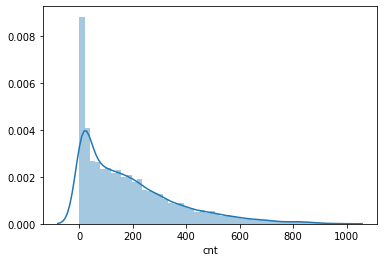

In [113]:
# distribution of count variable
sn.distplot(train["cnt"])

The distribution is skewed towards right and hence we can take log of the variable and see if the distribution becomes normal.

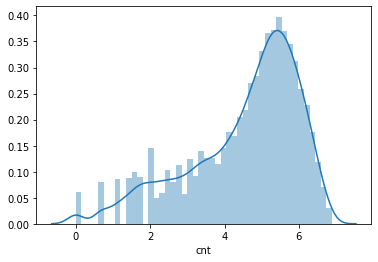

In [114]:
sn.distplot(np.log(train["cnt"]))

Looks less skewed now.Let's first look at the distribution of registered variable to check the number of registered user rentals initiated.

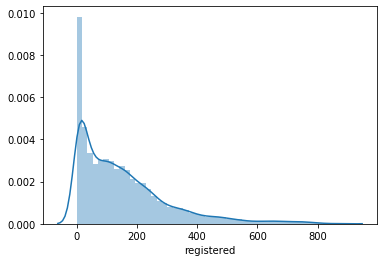

In [115]:
sn.distplot(train["registered"])

We can see that most of the registered rentals lies in the range of 0 to 200. The registered users at a particular time step will always be less than or equal to the demand (count) of that particular timestep.

Let's now look at how correlated our numerical variables are.

We will see the correlation between each of these variables and the variable which have high negative or positive values are correlated. By this we can get an overview of the variables which might affect our target variable.

# Bivariate Analysis

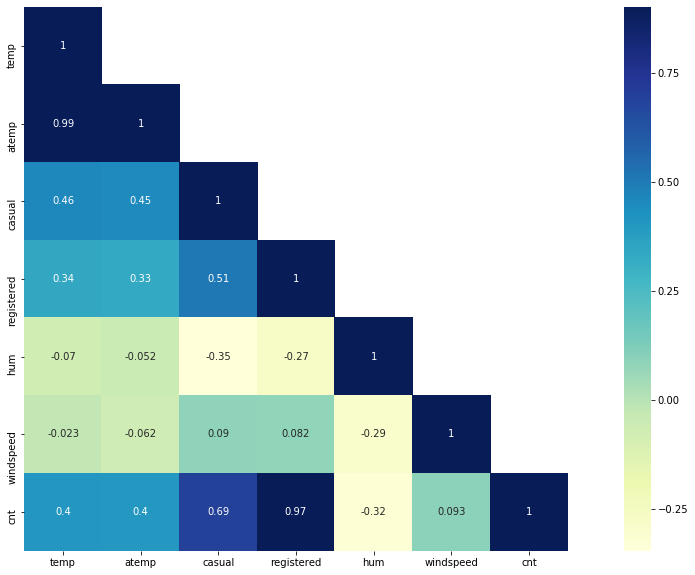

In [116]:
# looking at the correlation between numerical variables
corr=train[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()
mask=np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corr, mask=mask,vmax=.9, square=True,annot=True, cmap="YlGnBu")

Some of the inferences from the above correlation map are:

temp and humidity features has got positive and negative correlation with count respectively.Although the correlation between them are not very prominent still the count variable has got little dependency on "temp" and "humidity".

windspeed will not be really useful numerical feature and it is visible from it correlation value with "count"

Since "atemp" and "temp" has got strong correlation with each other, during model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.

Before building the model, let's check if there are any missing values in the dataset.

In [117]:
# looking for missing values in the datasaet
train.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Now our data is ready. Before making the model, we will create a validation set to validate our model. So, we will divide the train set into training and validation set. We will train the model on the training set and check its performance on the validation set.Let's take first 17 months for training and remaining 6 months in the validation set.

In [130]:
training = train[train['dteday']<='2012-07-31']
training.drop(['atemp','dteday'],axis=1,inplace=True)
training

C:\Users\RAJSHREE\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,1,0,1,0,0,6,0,1,0.24,0.81,0.0000,3,13,16
1,2,1,0,1,1,0,6,0,1,0.22,0.80,0.0000,8,32,40
2,3,1,0,1,2,0,6,0,1,0.22,0.80,0.0000,5,27,32
3,4,1,0,1,3,0,6,0,1,0.24,0.75,0.0000,3,10,13
4,5,1,0,1,4,0,6,0,1,0.24,0.75,0.0000,0,1,1
5,6,1,0,1,5,0,6,0,2,0.24,0.75,0.0896,0,1,1
6,7,1,0,1,6,0,6,0,1,0.22,0.80,0.0000,2,0,2
7,8,1,0,1,7,0,6,0,1,0.20,0.86,0.0000,1,2,3
8,9,1,0,1,8,0,6,0,1,0.24,0.75,0.0000,1,7,8
9,10,1,0,1,9,0,6,0,1,0.32,0.76,0.0000,8,6,14


In [119]:
validation = train[train['dteday']>'2012-07-31']
validation.drop(['atemp','dteday'],axis=1,inplace=True)
validation

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
13747,13748,3,1,8,0,0,3,1,1,0.68,0.79,0.1642,3,44,47
13748,13749,3,1,8,1,0,3,1,1,0.66,0.83,0.0896,5,28,33
13749,13750,3,1,8,2,0,3,1,1,0.64,0.83,0.1045,0,13,13
13750,13751,3,1,8,3,0,3,1,1,0.64,0.83,0.1045,0,7,7
13751,13752,3,1,8,4,0,3,1,2,0.64,0.78,0.1343,1,3,4
13752,13753,3,1,8,5,0,3,1,2,0.64,0.78,0.1343,3,46,49
13753,13754,3,1,8,6,0,3,1,1,0.64,0.78,0.1343,6,179,185
13754,13755,3,1,8,7,0,3,1,2,0.64,0.83,0.1343,19,468,487
13755,13756,3,1,8,8,0,3,1,2,0.66,0.78,0.1940,32,649,681
13756,13757,3,1,8,9,0,3,1,2,0.68,0.74,0.0896,34,316,350


dropped atemp column as it was highly correlated with temp, also dropped dteday as linear model does not work on timestamp type of data

# Model Building

## Linear Regression model

In [131]:
from sklearn.linear_model import LinearRegression

In [132]:
# initialize the linear regression model
lModel = LinearRegression()

In [133]:
X_train = training.drop('cnt', 1)
y_train = np.log(training['cnt'])

In [134]:
X_val = validation.drop('cnt', 1)
y_val = np.log(validation['cnt'])

In [124]:
# checking the shape of X_train, y_train, X_val and y_val
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((13747, 14), (13747,), (3632, 14), (3632,))

In [157]:
# fitting the model on X_train and y_train
lModel.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [158]:
# making prediction on validation set
prediction = lModel.predict(X_val)

In [127]:
# defining a function which will return the rmsle score
def rmsle(y, y_):
    y = np.exp(y),   # taking the exponential as we took the log of target variable
    y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [159]:
rmsle(y_val,prediction)

0.7572602036878169

In [163]:
test_prediction = lModel.predict(X_val)

# Decision Tree

In [146]:
from sklearn.tree import DecisionTreeRegressor

In [137]:
#defining a decision tree model with a depth of 5. We can further tune the hyperparameters to improve the score
dt_reg = DecisionTreeRegressor(max_depth=5)

In [147]:
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [149]:
predict = dt_reg.predict(X_val)

In [151]:
rmsle(y_val, predict)

0.13883441877595606

In [164]:
test_prediction = dt_reg.predict(X_val)

In [168]:
final_prediction = np.exp(test_prediction)

In [170]:
submission = pd.DataFrame()

In [172]:
submission['count'] = final_prediction

In [173]:
submission.to_csv('submission.csv', header=True, index=False)